In [1]:
import json

eval_PATH = 'data/test.json'
train_PATH = 'data/train.json'
val_PATH = 'data/validation.json'
pred_PATH = 'data_pred/main-pred-2enc-2dec.json'

e_trim = 100000
t_trim = 100000
v_trim = 100000

with open(eval_PATH, 'r') as f:
  eval_data = json.load(f)[:e_trim]
with open(train_PATH, 'r') as f:
  train_data = json.load(f)[:t_trim]
with open(val_PATH, 'r') as f:
  val_data = json.load(f)[:v_trim]
with open(pred_PATH, 'r') as f:
  pred_data = json.load(f)

In [2]:
from utils.transforms import construct_token_transform
token_transform = construct_token_transform()

/Users/batuel/Documents/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Decoding Methods
pred_data.keys()

dict_keys(['Greedy', 'Temperature 0.5', 'Temperature 1 (Unbiased)'])

In [4]:
eval_articles = [example['article'] for example in eval_data]
eval_summaries = [example['summary'] for example in eval_data]
train_articles = [example['article'] for example in train_data]
train_summaries = [example['summary'] for example in train_data]
val_articles = [example['article'] for example in val_data]
val_summaries = [example['summary'] for example in val_data]

pred_articles_grdy = [example['article'] for example in pred_data['Greedy']]
pred_summaries_grdy = [example['summary'] for example in pred_data['Greedy']]
pred_articles_unb = [example['article'] for example in pred_data['Temperature 1 (Unbiased)']]
pred_summaries_unb = [example['summary'] for example in pred_data['Temperature 1 (Unbiased)']]
pred_articles_temp = [example['article'] for example in pred_data['Temperature 0.5']]
pred_summaries_temp = [example['summary'] for example in pred_data['Temperature 0.5']]

In [5]:
tok_eval_articles = [token_transform(example) for example in eval_articles]
tok_eval_summaries = [token_transform(example) for example in eval_summaries]
tok_train_articles = [token_transform(example) for example in train_articles]
tok_train_summaries = [token_transform(example) for example in train_summaries]
tok_val_articles = [token_transform(example) for example in val_articles]
tok_val_summaries = [token_transform(example) for example in val_summaries]

tok_pred_articles_grdy = [token_transform(example) for example in pred_articles_grdy]
tok_pred_summaries_grdy = [token_transform(example) for example in pred_summaries_grdy]
tok_pred_articles_unb = [token_transform(example) for example in pred_articles_unb]
tok_pred_summaries_unb = [token_transform(example) for example in pred_summaries_unb]
tok_pred_articles_temp = [token_transform(example) for example in pred_articles_temp]
tok_pred_summaries_temp = [token_transform(example) for example in pred_summaries_temp]

In [6]:
import numpy as np
len_eval_art = np.array([len(art) for art in tok_eval_articles])
len_train_art = np.array([len(art) for art in tok_train_articles])

In [13]:
eval0_25index = len_eval_art < np.percentile(len_eval_art, 25)
eval25_50index = (len_eval_art > np.percentile(len_eval_art, 25)) & (len_eval_art < np.percentile(len_eval_art, 50))
eval50_75index = (len_eval_art > np.percentile(len_eval_art, 50)) & (len_eval_art < np.percentile(len_eval_art, 75))
eval75_100index = (len_eval_art > np.percentile(len_eval_art, 75)) 
eval90_100index = (len_eval_art > np.percentile(len_eval_art, 90))

In [14]:
len_eval_art[eval90_100index]

array([1984, 1501, 1963, 2067, 1398, 1452, 1681, 1296, 1505, 1480, 1371,
       1491, 1613, 1413, 1755, 1712, 1548, 1733, 1310, 1363, 1351, 1633,
       1443, 1502, 1324, 1484, 1352, 1460, 1676, 1440, 1291, 1295, 1507,
       1366, 1761, 1555, 1977, 1754, 2097, 1679, 1354, 1713, 1364, 1343,
       2043, 1382, 1823, 1399, 1971, 1355, 1405, 1438, 1617, 1931, 1474,
       1339, 1645, 1818, 1361, 1380, 1895, 1822, 1928, 1519, 1325, 1338,
       1623, 1393, 1789, 1627, 1755, 1338, 1325, 1697, 1439, 1444, 1516,
       1536, 1615, 1613, 2142, 2003, 1788, 1564, 1445, 1414, 1311, 1343,
       1326, 1368, 1354, 1340, 1706, 1300, 1762, 1499, 1730, 1582, 1766,
       1421])

In [15]:
import numpy as np
import pandas as pd
import tqdm
from rouge_metric import PyRouge
rouge = PyRouge(rouge_n=(1, 2, 4), rouge_l=True, rouge_w=True, rouge_s=True, rouge_su=True)

def pairwise_eval(rouge, pred_summary, eval_summary):
    scores = rouge.evaluate( [pred_summary], [[eval_summary]])
    #df = pd.DataFrame(scores).transpose().rename(columns={"r" : "Recall" ,"p" : "Precision" ,"f" : "F1-score" })
    return scores

scores_grdy = []
scores_unb = []
scores_temp = []

for sum_i in tqdm.tqdm(range(len(eval_summaries)), desc=''):
    scores_grdy.append(pairwise_eval(rouge , pred_summaries_grdy[sum_i] , eval_summaries[sum_i] ))
    scores_unb.append(pairwise_eval(rouge , pred_summaries_unb[sum_i] , eval_summaries[sum_i] ))
    scores_temp.append(pairwise_eval(rouge , pred_summaries_temp[sum_i] , eval_summaries[sum_i] ))

rouge_keys = list(scores_grdy[0].keys())
rouge_dict_grdy = {}
rouge_dict_unb = {}
rouge_dict_temp = {}

for key in rouge_keys:
    rouge_dict_grdy[key] = {}
    for rpf in  ['r']:
        rouge_dict_grdy[key] = [score[key][rpf] for score in scores_grdy]
        rouge_dict_unb[key] = [score[key][rpf] for score in scores_unb]
        rouge_dict_temp[key] = [score[key][rpf] for score in scores_temp]

100%|██████████| 1000/1000 [00:10<00:00, 93.12it/s]


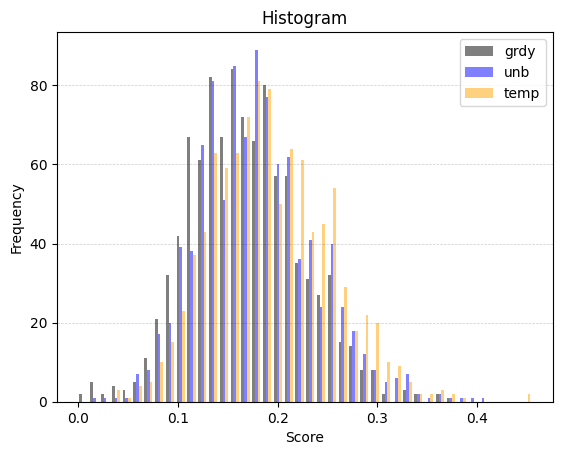

In [16]:
import matplotlib.pyplot as plt

rouge_metric = 'rouge-1'
d = [rouge_dict_grdy[rouge_metric], rouge_dict_unb[rouge_metric], rouge_dict_temp[rouge_metric]]
colors = ['black', 'blue', 'orange']
labels = ['grdy','unb','temp']

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=d, bins='auto', color=colors, alpha=0.5, rwidth=0.75, label=labels)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
# plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 2)
plt.legend()
plt.grid(color = 'black', linestyle = '--', linewidth = 0.5, axis='y', alpha=0.2)

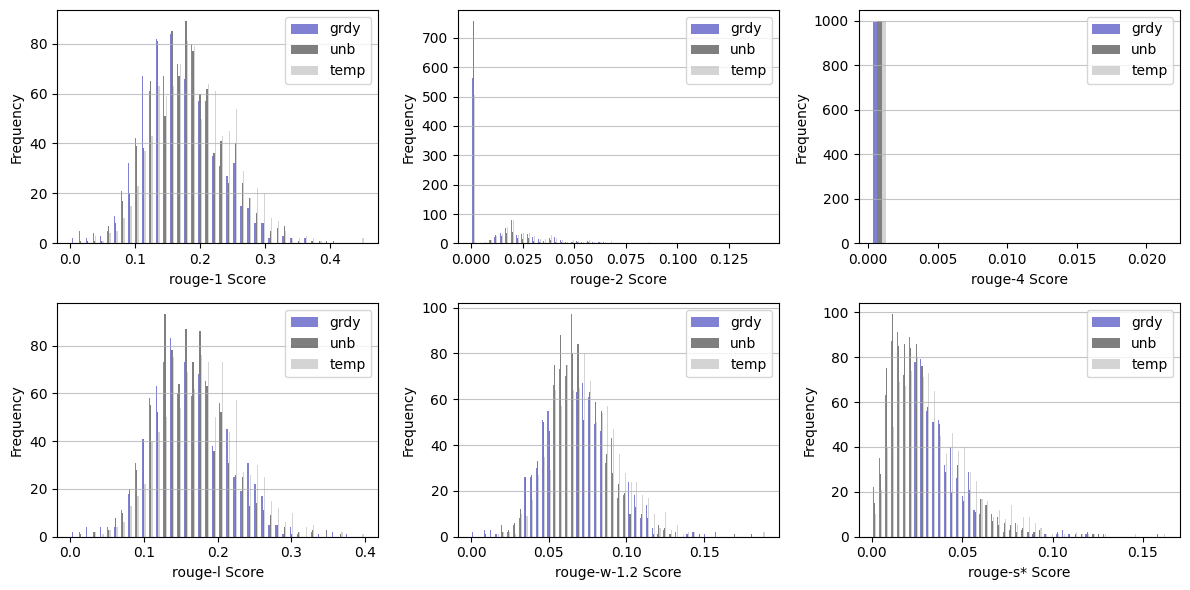

In [17]:
import matplotlib.pyplot as plt
import numpy as np

data=np.random.random((4,10))
xaxes = ['x1','x2','x3','x4']
yaxes = ['y1','y2','y3','y4']
titles = ['t1','t2','t3','t4'] 

colors = ['#0504aa', '#000000', '#aaaaaa']
labels = ['grdy','unb','temp']

f,a = plt.subplots(2,3,figsize=(12, 6))
a = a.ravel()
for idx,ax in enumerate(a):
    rouge_metric = list(rouge_dict_unb.keys())[idx]
    d = [rouge_dict_grdy[rouge_metric], rouge_dict_unb[rouge_metric], rouge_dict_temp[rouge_metric]]
    n, bins, patches = ax.hist(x=d, bins='auto', color=colors, alpha=0.5, rwidth=0.55, label=labels)
    ax.grid(axis='y', alpha=0.75)
    ax.set_xlabel(f'{rouge_metric} Score')
    ax.set_ylabel('Frequency')
    # ax.set_title('Histogram')
    # plt.text(23, 45, r'$\mu=15, b=3$')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    # plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 2)
    ax.legend()
plt.tight_layout()

In [18]:
from evaluation.rouge_evaluator import RougeEvaluator
import pandas as pd
evaluator = RougeEvaluator()
scores = evaluator.batch_score(np.array(pred_summaries_unb), np.array(eval_summaries))
df_scores = pd.DataFrame(scores).transpose().rename(columns={"r" : "Recall" ,"p" : "Precision" ,"f" : "F1-score" })
df_scores

,Recall,Precision,F1-score
rouge-1,0.179032,0.184718,0.181831
rouge-2,0.005640,0.005857,0.005746
rouge-4,0.000022,0.000017,0.000019
rouge-l,0.160648,0.166024,0.163292


In [19]:
d = {}

In [20]:
from evaluation.rouge_evaluator import RougeEvaluator
import pandas as pd

indexes = {"0-25": eval0_25index , "25-50": eval25_50index , "50-75":eval50_75index , "75-100":eval75_100index , "90-100":eval90_100index}
evaluator = RougeEvaluator()

df_dict = {}

for index in indexes:
    scores = evaluator.batch_score(np.array(pred_summaries_unb)[indexes[index]], np.array(eval_summaries)[indexes[index]])
    df_scores = pd.DataFrame(scores).transpose().rename(columns={"r" : "Recall" ,"p" : "Precision" ,"f" : "F1-score" })
    df_dict[index] = df_scores
df = pd.concat(df_dict)
d['Unbiased'] = df

In [21]:
from evaluation.rouge_evaluator import RougeEvaluator
import pandas as pd

indexes = {"0-25": eval0_25index , "25-50": eval25_50index , "50-75":eval50_75index , "75-100":eval75_100index , "90-100":eval90_100index}
evaluator = RougeEvaluator()

df_dict = {}

for index in indexes:
    scores = evaluator.batch_score(np.array(pred_summaries_grdy)[indexes[index]], np.array(eval_summaries)[indexes[index]])
    df_scores = pd.DataFrame(scores).transpose().rename(columns={"r" : "Recall" ,"p" : "Precision" ,"f" : "F1-score" })
    df_dict[index] = df_scores
df = pd.concat(df_dict)
d['Greedy'] = df

In [22]:
from evaluation.rouge_evaluator import RougeEvaluator
import pandas as pd

indexes = {"0-25": eval0_25index , "25-50": eval25_50index , "50-75":eval50_75index , "75-100":eval75_100index , "90-100":eval90_100index}
evaluator = RougeEvaluator()

df_dict = {}

for index in indexes:
    scores = evaluator.batch_score(np.array(pred_summaries_temp)[indexes[index]], np.array(eval_summaries)[indexes[index]])
    df_scores = pd.DataFrame(scores).transpose().rename(columns={"r" : "Recall" ,"p" : "Precision" ,"f" : "F1-score" })
    df_dict[index] = df_scores
df = pd.concat(df_dict)
d['Temperature'] = df

In [23]:
pd.concat(d, axis=1).round(3)

Unbiased                    Greedy                     \
                 Recall Precision F1-score Recall Precision F1-score   
0-25   rouge-1    0.181     0.187    0.184  0.171     0.214    0.190   
       rouge-2    0.006     0.006    0.006  0.013     0.016    0.015   
       rouge-4    0.000     0.000    0.000  0.000     0.000    0.000   
       rouge-l    0.163     0.168    0.165  0.164     0.205    0.182   
25-50  rouge-1    0.177     0.184    0.180  0.167     0.206    0.185   
       rouge-2    0.006     0.007    0.006  0.011     0.015    0.013   
       rouge-4    0.000     0.000    0.000  0.000     0.000    0.000   
       rouge-l    0.157     0.165    0.161  0.161     0.198    0.177   
50-75  rouge-1    0.179     0.178    0.178  0.164     0.200    0.181   
       rouge-2    0.005     0.005    0.005  0.011     0.014    0.012   
       rouge-4    0.000     0.000    0.000  0.000     0.000    0.000   
       rouge-l    0.159     0.160    0.160  0.158     0.193    0.174   
75-100 rouge-1    0.180     0.190    0.185  0.169     0.210    0.187   
       rouge-2    0.005     0.006    0.006  0.013     0.016    0.014   
       rouge-4    0.000     0.000    0.000  0.000     0.000    0.000   
       rouge-l    0.163     0.172    0.167  0.164     0.202    0.181   
90-100 rouge-1    0.180     0.195    0.187  0.166     0.205    0.184   
       rouge-2    0.005     0.005    0.005  0.012     0.015    0.013   
       rouge-4    0.000     0.000    0.000  0.000     0.000    0.000   
       rouge-l    0.163     0.176    0.169  0.162     0.199    0.179   

               Temperature                     
                    Recall Precision F1-score  
0-25   rouge-1       0.192     0.238    0.213  
       rouge-2       0.015     0.020    0.017  
       rouge-4       0.000     0.000    0.000  
       rouge-l       0.179     0.221    0.198  
25-50  rouge-1       0.192     0.232    0.210  
       rouge-2       0.013     0.016    0.014  
       rouge-4       0.000     0.000    0.000  
       rouge-l       0.179     0.217    0.196  
50-75  rouge-1       0.189     0.224    0.205  
       rouge-2       0.014     0.016    0.015  
       rouge-4       0.000     0.000    0.000  
       rouge-l       0.174     0.206    0.189  
75-100 rouge-1       0.195     0.233    0.213  
       rouge-2       0.016     0.019    0.017  
       rouge-4       0.000     0.000    0.000  
       rouge-l       0.182     0.217    0.198  
90-100 rouge-1       0.189     0.232    0.208  
       rouge-2       0.016     0.020    0.018  
       rouge-4       0.000     0.000    0.000  
       rouge-l       0.176     0.216    0.194

In [24]:
evaluator = RougeEvaluator()
scores = evaluator.batch_score(pred_summaries_grdy, eval_summaries)
df_scores = pd.DataFrame(scores).transpose().rename(columns={"r" : "Recall" ,"p" : "Precision" ,"f" : "F1-score" })
df_scores

,Recall,Precision,F1-score
rouge-1,0.167832,0.207403,0.185531
rouge-2,0.011987,0.015303,0.013444
rouge-4,0.000066,0.000118,0.000085
rouge-l,0.161721,0.199488,0.178631


In [25]:
evaluator = RougeEvaluator()
scores = evaluator.batch_score(pred_summaries_temp, eval_summaries)
df_scores = pd.DataFrame(scores).transpose().rename(columns={"r" : "Recall" ,"p" : "Precision" ,"f" : "F1-score" })
df_scores

,Recall,Precision,F1-score
rouge-1,0.192242,0.231579,0.210085
rouge-2,0.014511,0.017946,0.016047
rouge-4,0.000030,0.000050,0.000038
rouge-l,0.178742,0.214929,0.195172
